# Isotropic Scaling Experiment

## Synopsis

In this experiment, I will be looking at how the isotropic scaling effects the HSIC score for the HSIC and KA algorithms. In theory, because we are trying to find one parameter shared between the two kernel functions, there should be problems when the scale of one distribution is larger than another. It's a drawback of the method and it motivates the need to use two different parameters for the distributions.

## Code

In [1]:
import sys, os
# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

import warnings
import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.toy import generate_dependence_data, generate_isotropic_data

# Kernel Dependency measure
from models.train_models import get_gamma_init
from models.train_models import get_hsic
from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid
from models.ite_algorithms import run_rbig_models
from sklearn.preprocessing import StandardScaler

# Plotting
from visualization.distribution import plot_scorer
from visualization.scaling import plot_scorer_scale, plot_scorer_scale_norm


# experiment helpers
from tqdm import tqdm

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use(['fivethirtyeight', 'seaborn-poster'])
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline


%load_ext autoreload
%autoreload 2

### Experimental Design

The objective of this experiment is to measure how the Mutual information (MI) changes related to the HSIC score of different methods when we change the data and preprocessing conditions (normalization and scale). We change the nature of the data via the scale of the data received and whether or not we do a normalization procedure before we submit the datasets to our HSIC algorithms. Each HSIC method will give us a score and we can calculate the Mutual information

**Free Params**

* Number of Trials (`seed`)
    * 1:10
* Scale or not scaled (`scale`)
* Normalized | Not Normalized (`normalize`)
* HSIC Algorithm (`method`)
    * HSIC, KA, cKA
* Dataset (`dataset`)
    * Linear, Sinusoidal, Circle, Random
* Amount of Noise (`noise` List)
    * log space 

**Measurements**

* Mutual Information (`mi`)
* HSIC score (`score`)
* Time for execution (`time`)

**Fixed Parameters**

* Number of points (`num_points`)
* Noise for X points (`noise_x`)
* Noise for Y points (`noise_y`)
* 

In [2]:
from typing import Optional

SAVE_PATH = '/home/emmanuel/figures/hsicalign/'
plt.style.use(['seaborn-talk'])
def plot_results(df: pd.DataFrame, scorer: str, hue: Optional[str]=None, style: Optional[str]=None, save_name: Optional[str]=None)-> None:
    
    df = df[df['scorer'] == scorer]
    
    # plot data
    fig, ax = plt.subplots()

    pts = sns.scatterplot(
        x='hsic_value',
        y='mi',
        hue=hue,
        style=style,
        data=df
    )
    ax.set_ylabel('Mutual Information', fontsize=20)
    ax.set_xlabel('Score', fontsize=20)
    ax.legend(fontsize=20)
    if save_name is not None:
        fig.savefig(SAVE_PATH + f"{scorer}_{save_name}.png")
    plt.show()
    return

### Data

In [3]:
cwd

'/home/emmanuel/projects/2019_hsic_align/notebooks/3_isotropic_scaling'

In [4]:
PROJECT_PATH = f"{cwd}/../../"


RES_PATH = PROJECT_PATH + 'data/results/scaling/'
RES_PATH

'/home/emmanuel/projects/2019_hsic_align/notebooks/3_isotropic_scaling/../../data/results/scaling/'

In [8]:
!ls '/home/emmanuel/projects/2019_hsic_align/notebooks/3_isotropic_scaling/../../data/results/scaling/'

exp_scale_c1.csv     exp_scale_c2_v2.csv  exp_scale_c4.csv
exp_scale_c1_v1.csv  exp_scale_c2_v3.csv  exp_scale_c4_v1.csv
exp_scale_c1_v2.csv  exp_scale_c3.csv	  exp_scale_c4_v2.csv
exp_scale_c1_v3.csv  exp_scale_c3_v1.csv  exp_scale_c4_v3.csv
exp_scale_c2.csv     exp_scale_c3_v2.csv  exp_scale_test.csv
exp_scale_c2_v1.csv  exp_scale_c3_v3.csv  scaling_v1.csv


### Case I - Unscaled, Unnormalized

For this first walkthrough, we are assuming that the data is unscaled and that the data is unnormalized. 

**Hypothesis**: We all methods should showcase some relationship to the amount of Mutual information but it will not necessarily be a strict relationship. Thinking from the previous results, the KA method should perform the worst, the HSIC method should perform OK with some inconsistencies and the CKA should perform the best and showcase a trend.

In [13]:
results_df = pd.read_csv(RES_PATH + 'exp_scale_test.csv', index_col=0)
results_df.tail()

,dataset,each,gamma_method,hsic_value,mi,noise,normalized,scale,scorer,trial
2395,sine,0.0,median_p0.5,0.194763,0.0,10.0,0.0,100.0,tka,1.0
2396,sine,0.0,median_p0.5,0.008053,0.0,10.0,0.0,100.0,ctka,1.0
2397,sine,1.0,median_p0.5,0.000585,0.0,10.0,0.0,100.0,hsic,1.0
2398,sine,1.0,median_p0.5,0.673256,0.0,10.0,0.0,100.0,tka,1.0
2399,sine,1.0,median_p0.5,0.006027,0.0,10.0,0.0,100.0,ctka,1.0


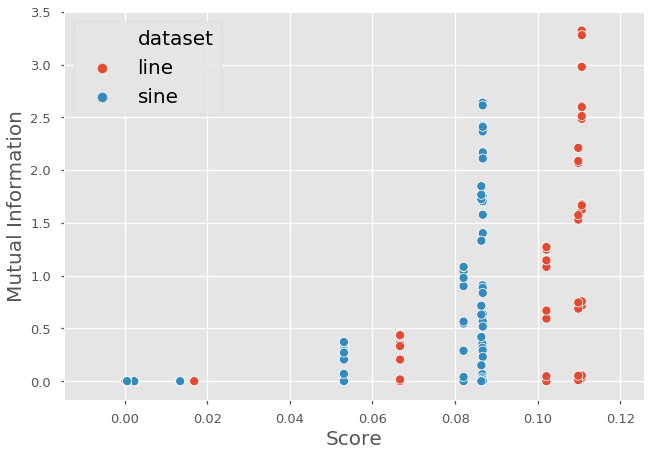

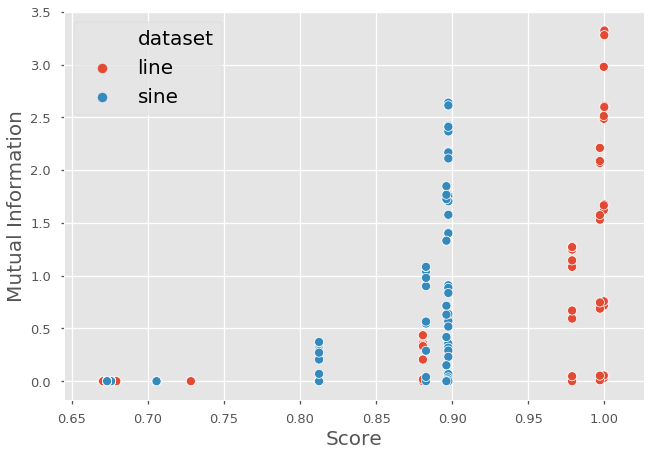

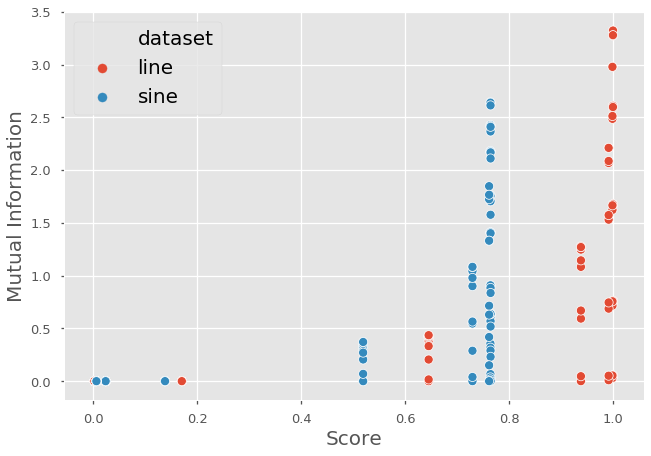

In [14]:


sub_df = results_df.copy()
# sub_df = sub_df[sub_df['dataset'] == 'line']
sub_df = sub_df[sub_df['normalized'] == 0.0]
sub_df = sub_df[sub_df['each'] == 1.0]
sub_df = sub_df[sub_df['gamma_method'] == 'median_p0.5']
# sub_df = sub_df[sub_df['scorer'] == 'ctka']
# sub_df = sub_df[sub_df['trial'] == 1.0]
# sub_df['mi'] = np.log2(sub_df['mi'])

# plot data
plot_results(sub_df, 'hsic', 'dataset', save_name="case2_sep")
plot_results(sub_df, 'tka', 'dataset')
plot_results(sub_df, 'ctka', 'dataset')

In [7]:
results_df.head()

,Unnamed: 0,dataset,gamma_method,hsic_value,mi,noise,normalized,scale,scorer,trial
0,0,line,median_p0.2,0.112773,3.132759,0.01,0.0,1.0,hsic,1.0
1,1,line,median_p0.2,0.995687,3.132759,0.01,0.0,1.0,tka,1.0
2,2,line,median_p0.2,0.993657,3.132759,0.01,0.0,1.0,ctka,1.0
3,3,line,median_p0.4,0.125462,3.132759,0.01,0.0,1.0,hsic,1.0
4,4,line,median_p0.4,0.999011,3.132759,0.01,0.0,1.0,tka,1.0


### Case II - UnScaled, Normalized

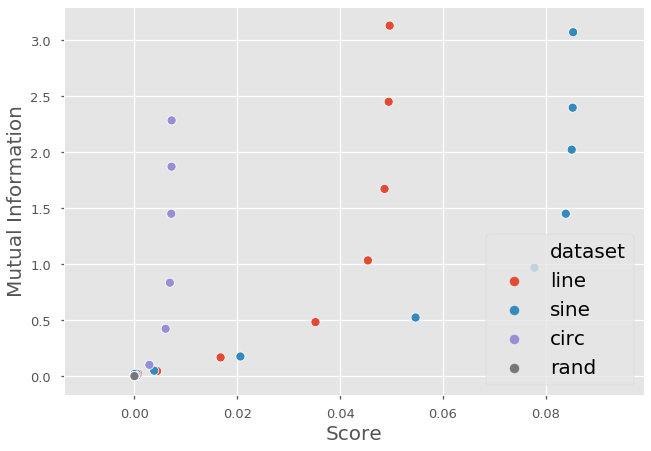

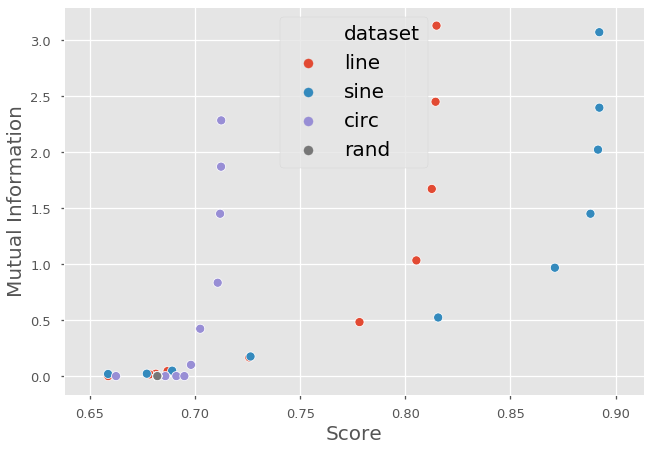

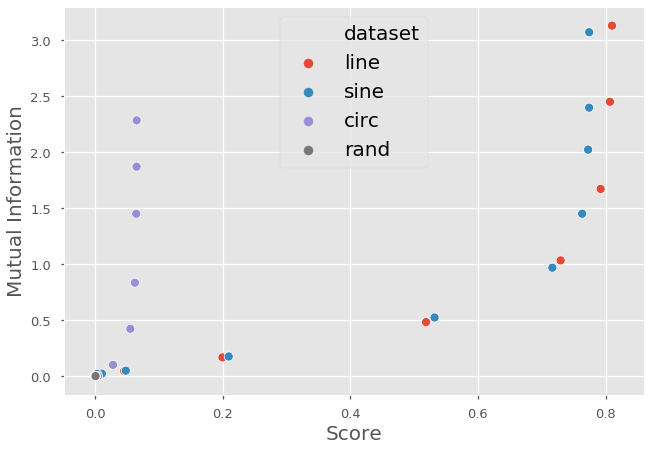

In [10]:
results_df = pd.read_csv(RES_PATH + 'exp_scale_c2.csv')

sub_df = results_df.copy()
# sub_df = sub_df[sub_df['dataset'] == 'line']
sub_df = sub_df[sub_df['normalized'] == 1.0]
sub_df = sub_df[sub_df['gamma_method'] == 'median_p0.5']
# sub_df = sub_df[sub_df['scorer'] == 'hsic']
# sub_df = sub_df[sub_df['trial'] == 1.0]
# sub_df['mi'] = np.log2(sub_df['mi'])

# plot data
plot_results(sub_df, 'hsic', 'dataset', save_name="case2_sep")
plot_results(sub_df, 'tka', 'dataset')
plot_results(sub_df, 'ctka', 'dataset', save_name="case2_same")

### Case III - Scaled, Unnormalized

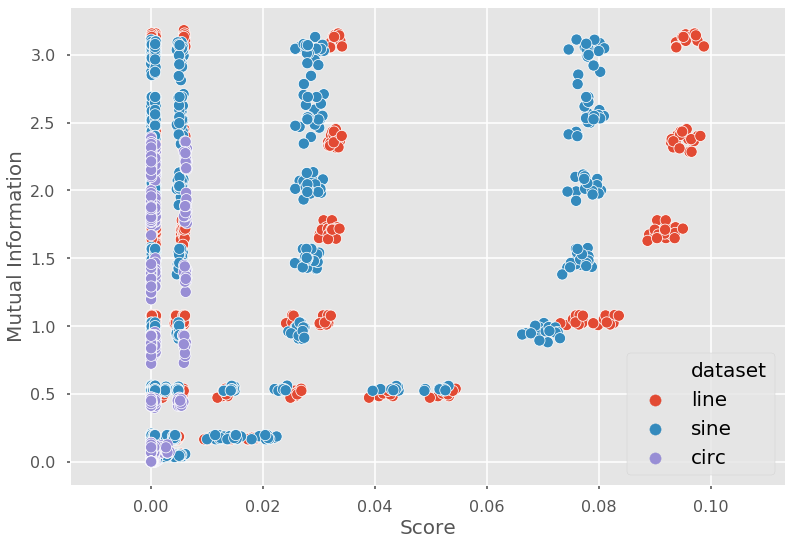

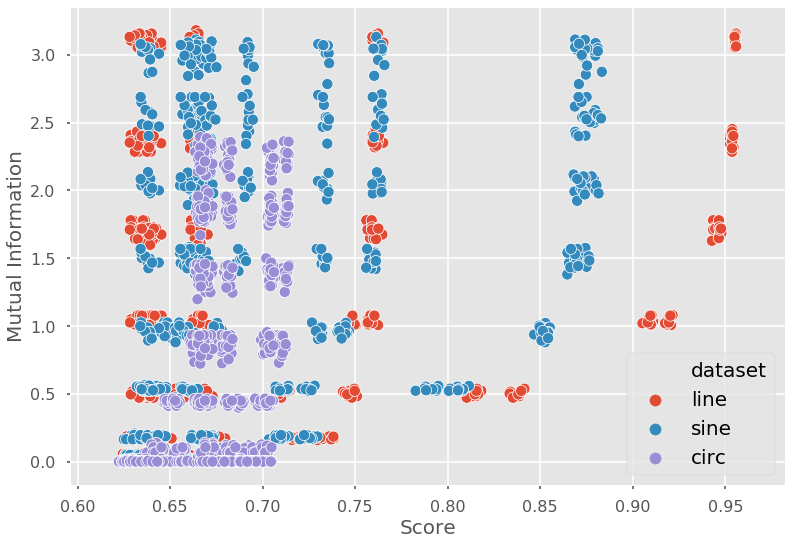

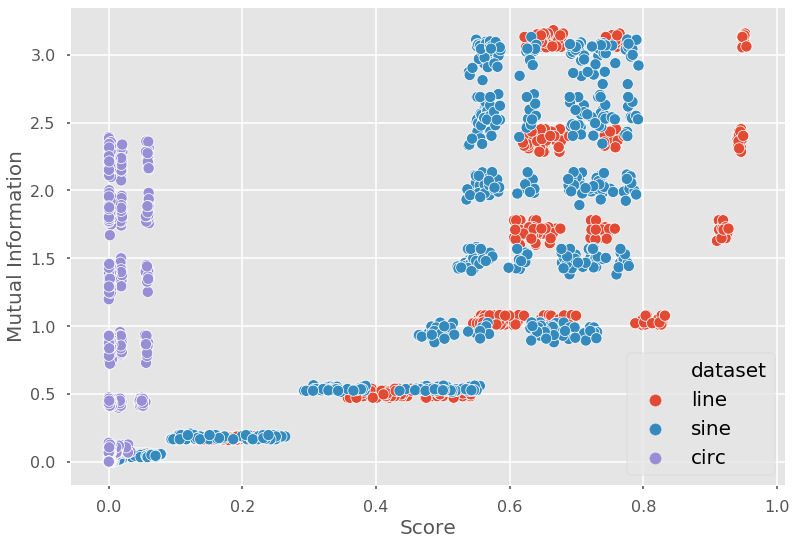

In [13]:
results_df = pd.read_csv(RES_PATH + 'exp_scale_c3_v2.csv')
sub_df = results_df.copy()

# sub_df = sub_df[sub_df['dataset'] == 'sine']
sub_df = sub_df[sub_df['normalized'] == 0.0]
sub_df = sub_df[sub_df['gamma_method'] == 'median_p0.5']
# sub_df = sub_df[sub_df['scorer'] == 'ctka']
# sub_df = sub_df[sub_df['trial'] == 1.0]
# sub_df['mi'] = np.log2(sub_df['mi'])

# plot data
plot_results(sub_df, 'hsic', 'dataset')
plot_results(sub_df, 'tka', 'dataset')
plot_results(sub_df, 'ctka', 'dataset')

### Case IV - Scaled, Normalized

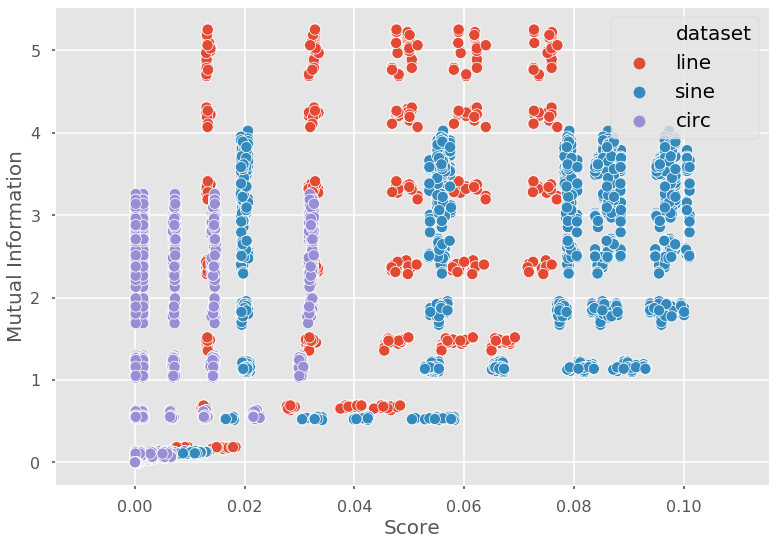

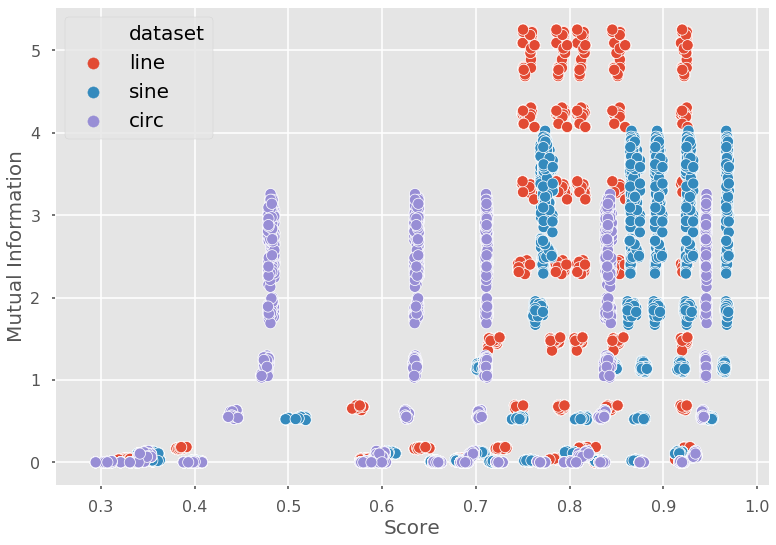

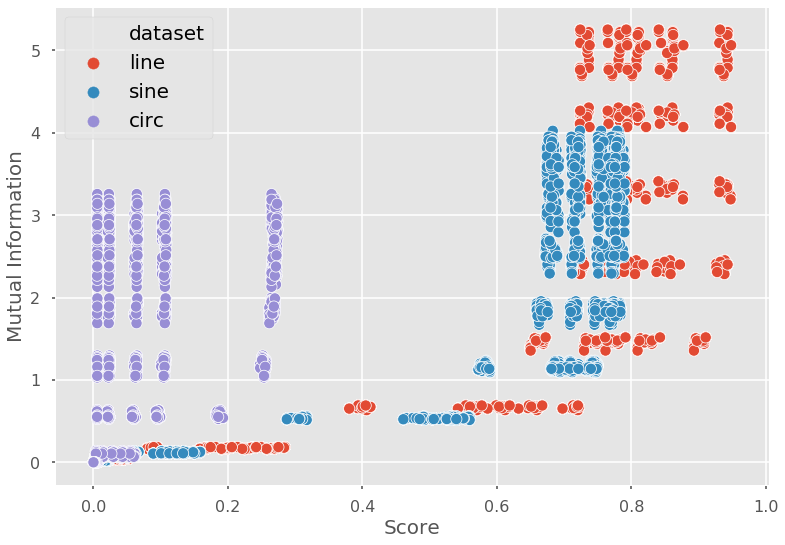

In [20]:
results_df = pd.read_csv(RES_PATH + 'exp_scale_c4_v2.csv')

sub_df = results_df.copy()
# sub_df = sub_df[sub_df['dataset'] == 'circ']
sub_df = sub_df[sub_df['normalized'] == 1.0]
# sub_df = sub_df[sub_df['gamma_method'] == 'median_p0.5']
# sub_df = sub_df[sub_df['scorer'] == 'ctka']
# sub_df = sub_df[sub_df['trial'] == 1.0]
# sub_df['mi'] = np.log2(sub_df['mi'])

# plot data
plt.style.use(['seaborn-poster'])
plot_results(sub_df, 'hsic', 'dataset', save_name="case4_same")
plot_results(sub_df, 'tka', 'dataset')
plot_results(sub_df, 'ctka', 'dataset', save_name="case4_same")